# Using Climate and Soil Data to Predict Crop Yeilds

In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Dense

from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score

In [220]:
# The first kind of data used is Yield Data collected from the USDA NASS QuickStat 
corn = pd.read_csv('data/corn.csv').set_index(['Year','ANSI'])
corn.columns = ['corn']
soy = pd.read_csv('data/soy.csv').set_index(['Year','ANSI'])
soy.columns = ['soy']
wheat = pd.read_csv('data/wheat.csv').set_index(['Year','ANSI'])
wheat.columns = ['wheat']
crops = corn.join(soy).join(wheat)
crops = crops.stack().reset_index()
crops = crops.join(pd.get_dummies(temp['level_2']))
crops = crops.set_index(['Year','ANSI'])[[0,'corn','soy','wheat']]

# The second kind of data is Soil Data from Conservation Science Partners via Google Earth Engine(https://developers.google.com/earth-engine/datasets/catalog/CSP_ERGo_1_0_US_lithology)
soil = pd.read_csv('data/soilclust.csv')
soil['Clust']=soil['Clust'].apply(int)

# The third and final data set is climate (temp and rain) data from NASA ORNL DAAC at Oak Ridge National Laboratory collected via Google Earth Engine (https://developers.google.com/earth-engine/datasets/catalog/NASA_ORNL_DAYMET_V3)
climate = pd.read_csv('data/climate.csv')
climate['Date']=pd.to_datetime(climate['Date'])
climate['Month']=climate['Date'].apply(lambda x:x.month)
climate['Year']=climate['Date'].apply(lambda x:x.year)
climate = climate.set_index(['Clust','Year','Month'])[['prcp','tmax','tmin']].stack().reset_index()
climate['label'] = climate['level_3']+'_'+climate['Month'].apply(str)
climate['Clust']=climate['Clust'].apply(int)
climate=climate.set_index(['Clust','Year','label'])[0]
climate=climate.unstack()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C71F515EC8>]],
      dtype=object)

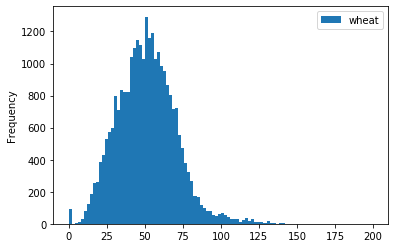

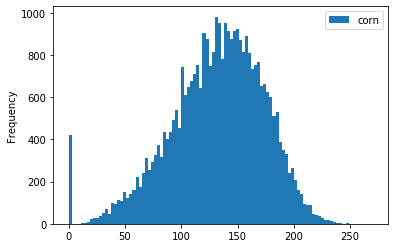

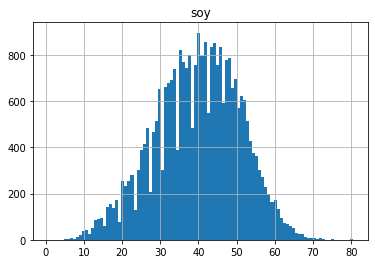

In [197]:
# We are looking to predict the yields
wheat.plot.hist(bins=100)
corn.plot.hist(bins=100)
soy.hist(bins=100)

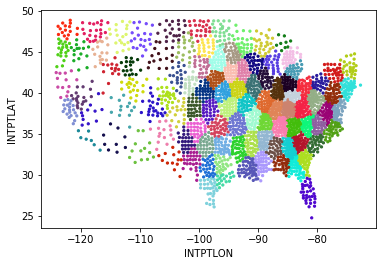

In [200]:
# As shown below, clusters were selected to be geographicly adjacent to each other while at the same time having similar compostions of soils
colors = pd.DataFrame(np.random.rand(3,100))
colors = soil['Clust'].apply(lambda x:colors[x].values)
soil.plot.scatter('INTPTLON','INTPTLAT',s=5,c=colors,)

In [351]:
#Now we create a data frame where we can train
#first we join crop data with soil data
df = crops.reset_index().set_index('ANSI').join(soil.set_index('fips').drop(columns=['INTPTLAT','INTPTLON'])).reset_index()

#Next we join the dataframe with climate data
columns = df.columns.tolist()
columns[-1]='Clust'
df.columns = columns
df['Clust']=df['Clust']#.apply(str)
df=df.set_index(['Clust','Year'])

# Join the climate data from that year
df = df.join(climate)

# Join the climate data from the previous year
df = df.join(climate.reset_index().set_index(['Year','Clust']).unstack().shift(1).stack(),rsuffix='_-1')
df=df.reset_index()

In [350]:
df

index      0  corn  soy  wheat         1    2         3    4    5  \
Clust Year                                                                      
0     2000  20019  115.0     1    0      0  0.000000  0.0  0.929101  0.0  0.0   
      2000  20019    9.0     0    1      0  0.000000  0.0  0.929101  0.0  0.0   
      2000  20019   32.0     0    0      1  0.000000  0.0  0.929101  0.0  0.0   
      2000  20035   93.0     1    0      0  0.000000  0.0  0.780487  0.0  0.0   
      2000  20035   22.0     0    1      0  0.000000  0.0  0.780487  0.0  0.0   
...           ...    ...   ...  ...    ...       ...  ...       ...  ...  ...   
99    2019   1069   46.2     0    1      0  0.712407  0.0  0.145205  0.0  0.0   
      2019   1099  124.1     1    0      0  0.095540  0.0  0.602053  0.0  0.0   
      2019  13099  202.0     1    0      0  0.869239  0.0  0.120371  0.0  0.0   
      2019  13243  213.0     1    0      0  0.425947  0.0  0.574053  0.0  0.0   
      2019  13253  213.0     1    0      0  0.925197  0.0  0.000000  0.0  0.0   

            ...  tmin_11_-1  tmin_12_-1  tmin_2_-1  tmin_3_-1  tmin_4_-1  \
Clust Year  ...                                                            
0     2000  ...         NaN         NaN        NaN        NaN        NaN   
      2000  ...         NaN         NaN        NaN        NaN        NaN   
      2000  ...         NaN         NaN        NaN        NaN        NaN   
      2000  ...         NaN         NaN        NaN        NaN        NaN   
      2000  ...         NaN         NaN        NaN        NaN        NaN   
...         ...         ...         ...        ...        ...        ...   
99    2019  ...   -2.173806   -3.162866  -5.661959   1.276372   1.728747   
      2019  ...   -2.173806   -3.162866  -5.661959   1.276372   1.728747   
      2019  ...   -2.173806   -3.162866  -5.661959   1.276372   1.728747   
      2019  ...   -2.173806   -3.162866  -5.661959   1.276372   1.728747   
      2019  ...   -2.173806   -3.162866  -5.661959   1.276372   1.728747   

            tmin_5_-1  tmin_6_-1  tmin_7_-1  tmin_8_-1  tmin_9_-1  
Clust Year                                                         
0     2000        NaN        NaN        NaN        NaN        NaN  
      2000        NaN        NaN        NaN        NaN        NaN  
      2000        NaN        NaN        NaN        NaN        NaN  
      2000        NaN        NaN        NaN        NaN        NaN  
      2000        NaN        NaN        NaN        NaN        NaN  
...               ...        ...        ...        ...        ...  
99    2019  15.607889  19.334206  20.205403  19.001041  16.536122  
      2019  15.607889  19.334206  20.205403  19.001041  16.536122  
      2019  15.607889  19.334206  20.205403  19.001041  16.536122  
      2019  15.607889  19.334206  20.205403  19.001041  16.536122  
      2019  15.607889  19.334206  20.205403  19.001041  16.536122  

[82147 rows x 96 columns]

In [358]:
# Now we split the data into test and training
# The last three years(17,18,and 19) will be reserved for testing while the rest is training
train = df[df['Year']<2017].reset_index().dropna()
test = df[df['Year']>=2017].reset_index()

transformer = Normalizer()

trainy = train.iloc[:,4]
trainx = train.iloc[:,5:]


testy = test.iloc[:,4]
testx = test.iloc[:,5:]

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 75)                7125      
_________________________________________________________________
dense_50 (Dense)             (None, 50)                3800      
_________________________________________________________________
dense_51 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_52 (Dense)             (None, 5)                 130       
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 6         
Total params: 12,336
Trainable params: 12,336
Non-trainable params: 0
_________________________________________________________________
Train on 54514 samples, validate on 13629 samples
Epoch 1/25
54514/54514 [==============================] - 7s 127u

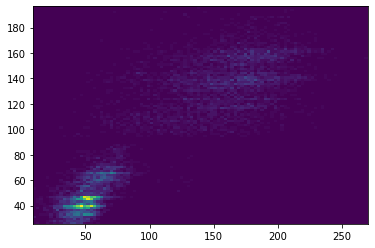

0.7707594267645265


In [363]:
import keras
#This is the Neural Network model for the data
model = Sequential()
model.add(Dense(75,input_dim=94,activation='relu',)) ### kernel_initializer='normal', ))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='relu'))
model.summary()
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

model.fit(trainx, trainy, epochs=25, batch_size=10,  verbose=1, validation_split=0.2)

predy = model.predict(testx).flatten()
plt.hist2d(testy,predy,bins=100)
plt.show()

print(r2_score(testy,predy))